In [1]:
import torch
print(torch.__version__)

import torch.nn as nn

import torchvision
from torchvision import datasets

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from models import AutoEncoder
from tqdm.auto import tqdm

import numpy as np
import seaborn as sns
sns.set()

import pandas as pd

1.7.0


In [2]:
mnist_trainset = datasets.MNIST(root="../data/", train=True,
                                download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ]))

mnist_valid = datasets.MNIST(root="../data/", train=False,
                             download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

In [3]:
mnist_trainset[7][0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [4]:
model = AutoEncoder().to("cuda")
loss_fn = nn.MSELoss().to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=1, shuffle=False)

In [5]:
for epoch in range(10):

    train_loss = 0
    valid_loss = 0

    model.train()
    for images, labels in tqdm(dataloader, leave=False):
        optimizer.zero_grad()
        output = model(images.to("cuda"))
        loss = loss_fn(output, images.to("cuda"))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(dataloader)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, leave=False):
            output = model(images.to("cuda"))
            loss = loss_fn(output, images.to("cuda"))
            valid_loss += loss.item() / len(valid_loader)

    print(f"Epoch {epoch+1}: train_loss {train_loss}, valid_loss {valid_loss}")

Epoch 1: train_loss 0.5957969448713869, valid_loss 0.5259432806622243
Epoch 2: train_loss 0.5115690648809936, valid_loss 0.4927881329096842
Epoch 3: train_loss 0.48504339701839616, valid_loss 0.46912917510196595
Epoch 4: train_loss 0.46323655390027757, valid_loss 0.4520329754013561
Epoch 5: train_loss 0.44652485669548847, valid_loss 0.4408753384612506
Epoch 6: train_loss 0.4344878509990192, valid_loss 0.4325078287664806
Epoch 7: train_loss 0.4257146187428475, valid_loss 0.4259177755832663
Epoch 8: train_loss 0.41766615869648144, valid_loss 0.4163372529078264
Epoch 9: train_loss 0.4116283470887876, valid_loss 0.4115205482391636
Epoch 10: train_loss 0.4068534327214206, valid_loss 0.4075818705279374


In [6]:
points = []
colors = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        output = model.encoder(images.to("cuda"))
        points.append(output.squeeze(0).cpu().detach().numpy())
        colors.append(labels[0].detach().numpy())

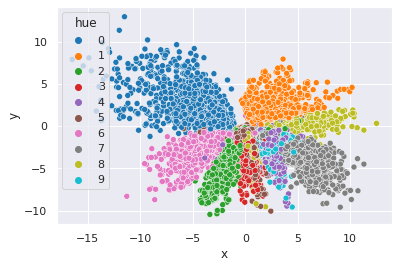

In [16]:
np_points = np.vstack(points)
np_colors = np.stack(colors).tolist()
data = pd.DataFrame({'x': np_points[:,0], 'y': np_points[:,1], 'hue': np_colors})
sns.scatterplot(x='x', y='y', hue='hue', data=data, palette="tab10")
plt.show()

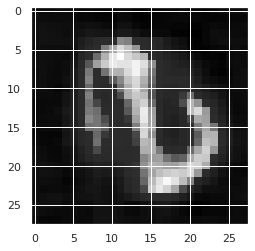

In [33]:
plt.imshow(
    model.decoder(
        torch.tensor(
            [-1., 5.]
        ).unsqueeze(0).unsqueeze(0).cuda()
    ).cpu().squeeze(0).squeeze(0).detach().numpy(),
    cmap="gray"
)